# Precipitation and Temperature Data Processing and Visualization for Nepal 2050

## Overview
This notebook processes precipitation and temperature raster data for Nepal projected for the year 2050 and 2020 by applying a geospatial mask using a shapefile boundary. The masked data is then visualized using a professionally styled plot with Matplotlib. The script is designed to be robust, modular, and reusable, with proper error handling and logging.

## Dependencies
The script relies on the following Python libraries:
- **matplotlib**: For plotting the masked raster data.
- **rasterio**: For reading and masking raster files.
- **geopandas**: For reading shapefiles.
- **numpy**: For handling raster data as arrays.
- **pathlib**: For cross-platform file path handling.
- **logging**: For logging process status and errors.

### Step 1: Installation of libraries and ensuring the working of python
To set up the environment:
1. Ensure Python 3.12 or higher is installed.
2. Install the required dependencies:
   ```bash
   pip install -r requirements.txt

### Step 2: Documentation - File Structure

- **Input Files**:
  
  - `precipitation_2050.tif`: Raster file containing precipitation data for Nepal in 2050.
  - 'precipitation_2020.tif': Raster file containing precipitation data for Nepal in 2020.
  - 'temperature_2050.tif': Raster file contatining temprature data for Nepal in 2050.
  - 'temperature_2020.tif': Raster file contatining temprature data for Nepal in 2020.
  - `nepal_boundary.shp`: Shapefile defining the boundary of Nepal for masking.
  - 
- **Output Files**:
  - `nepal_precipitation_2050.png`
  - 'nepal_temperature_2050.png'
  -  `nepal_precipitation_2020.png`
  -  `nepal_temperature_2020.png`

### Step 3: Importing Libraires

In [19]:
import matplotlib.pyplot as plt # plotting graphs
import rasterio #for reading raster file 
import rasterstats # performs statistical operation on raster data
from rasterio.mask import mask  # mask rasterdataset based on given shape file
import geopandas as gpd # for handling shapefiles
import numpy as np # for numerical calculations
from pathlib import Path  # for cross-platform file path handling
from typing import Union, Optional # for type hint
import logging # for logging process status and errors
import os # for checking the directory writability

# configuring logging for providing runtime feedback

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__) # create a logger instance

# Function to check if the directory is writable

def is_writable(directory: Union[str,Path]) -> bool:

    '''
    check if directory is writable.

    Args:
        directory (Union[str,Path]): Path to the directory.

    Returns:
        bools: true if writable, False otherwise.
    '''

    directory = Path(directory)
    try:
        test_file = directory/ ".test_writability"
        with open (test_file, 'w') as f:
            f.write('test')
        return True
    except(OSError, PermissionError):
        return False




### Step 4: Mask_Raster Function

In [14]:
# we will define a mask function to mask raster data with shapefile

def mask_raster(raster_path: Union[str, Path], shapefile_path: Union[str, Path]) -> np.ndarray:
    try:
        # Convert input paths to Path objects
        raster_path = Path(raster_path)
        shapefile_path = Path(shapefile_path)

        # Check if files exist
        if not raster_path.exists():
            raise FileNotFoundError(f"Raster file not found: {raster_path}")
        if not shapefile_path.exists():
            raise FileNotFoundError(f"Shapefile not found: {shapefile_path}")

        # Read the shapefile
        gdf = gpd.read_file(shapefile_path)
        logger.info(f"Shapefile loaded successfully: {shapefile_path}")

        # Extract geometries
        shapes = [geom for geom in gdf.geometry]

        # Open raster and apply mask
        with rasterio.open(raster_path) as src:
            masked_data, _ = mask(src, shapes, crop=True, nodata=np.nan)
            logger.info(f"Raster masked successfully: {raster_path}")

        # Return the first band of the masked data
        return masked_data[0]

    except Exception as e:
        # Log any error that occurs during the process
        logger.error(f"Error in mask_raster: {str(e)}")
        return None  # Return None in case of failure

### Step 5: Plot Masked_Raster Function 

In [17]:
def plot_masked_raster(masked_data: np.ndarray, title: str, output_path: Optional[Union[str, Path]] = None, unit: str = 'Value') -> None:
    """
    Plots the masked raster data with a professional layout, displays it, and optionally saves it.

    Args:
        masked_data (np.ndarray): Masked raster data to plot.
        title (str): Title of the plot.
        output_path (Optional[Union[str, Path]]): Path to save the plot. If provided, saves the plot.
        unit (str): Unit for the colorbar label (default: "Value").

    Raises:
        ValueError: If masked_data is not a valid NumPy array.
        OSError: If the output path is not writable.
    """
    try:
        # Validate that the input is a NumPy array
        if not isinstance(masked_data, np.ndarray):
            raise ValueError("masked_data must be a NumPy array")

        # Create a figure with a high-resolution, professional layout
        plt.figure(figsize=(10, 8), dpi=300)
        plt.imshow(masked_data, cmap="Sequential" if "Precipitation" in title else "Reds", interpolation='nearest')  # Blues for precip, Reds for temp
        plt.title(title, fontsize=14, fontweight='bold', pad=15)  # Set title with styling
        plt.colorbar(label=unit, shrink=0.8, aspect=20, pad=0.02)  # Use provided unit in colorbar
        plt.xlabel("Longitude", fontsize=12)  # Label x-axis
        plt.ylabel("Latitude", fontsize=12)  # Label y-axis
        plt.xticks(fontsize=10)  # Set tick font size
        plt.yticks(fontsize=10)
        plt.grid(False)  # Disable grid for cleaner look

        # Adjust layout to prevent clipping of elements
        plt.tight_layout()

        # Save the plot if an output path is provided
        if output_path is not None:
            # Ensure output_path is a Path object and absolute
            output_path = Path(output_path).resolve()
            # Check if the parent directory is writable
            if not is_writable(output_path.parent):
                raise OSError(f"Cannot save plot: directory '{output_path.parent}' is not writable")
            plt.savefig(output_path, bbox_inches='tight', format='png')
            logger.info(f"Plot saved to: {output_path}")

        # Always display the plot in the notebook
        plt.show()
        logger.info(f"Plot displayed for: {title}")

    except Exception as e:
        # Log any errors during plotting
        logger.error(f"Error in plot_masked_raster: {str(e)}")
        raise
    finally:
        plt.close()

### Step 6: Execute Main Process

2025-03-18 11:19:39,218 - INFO - Output directory set to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output
2025-03-18 11:19:39,219 - INFO - Starting raster masking process for Precipitation 2020...
2025-03-18 11:19:39,282 - INFO - Shapefile loaded successfully: data/Shape_Data/local_unit.shp
2025-03-18 11:19:40,134 - INFO - Raster masked successfully: data/nepal_climate_data/nepal_precipitation_2020.tif
2025-03-18 11:19:40,136 - INFO - Generating plot for Precipitation 2020...
2025-03-18 11:19:40,471 - INFO - Plot saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_precipitation_2020.png


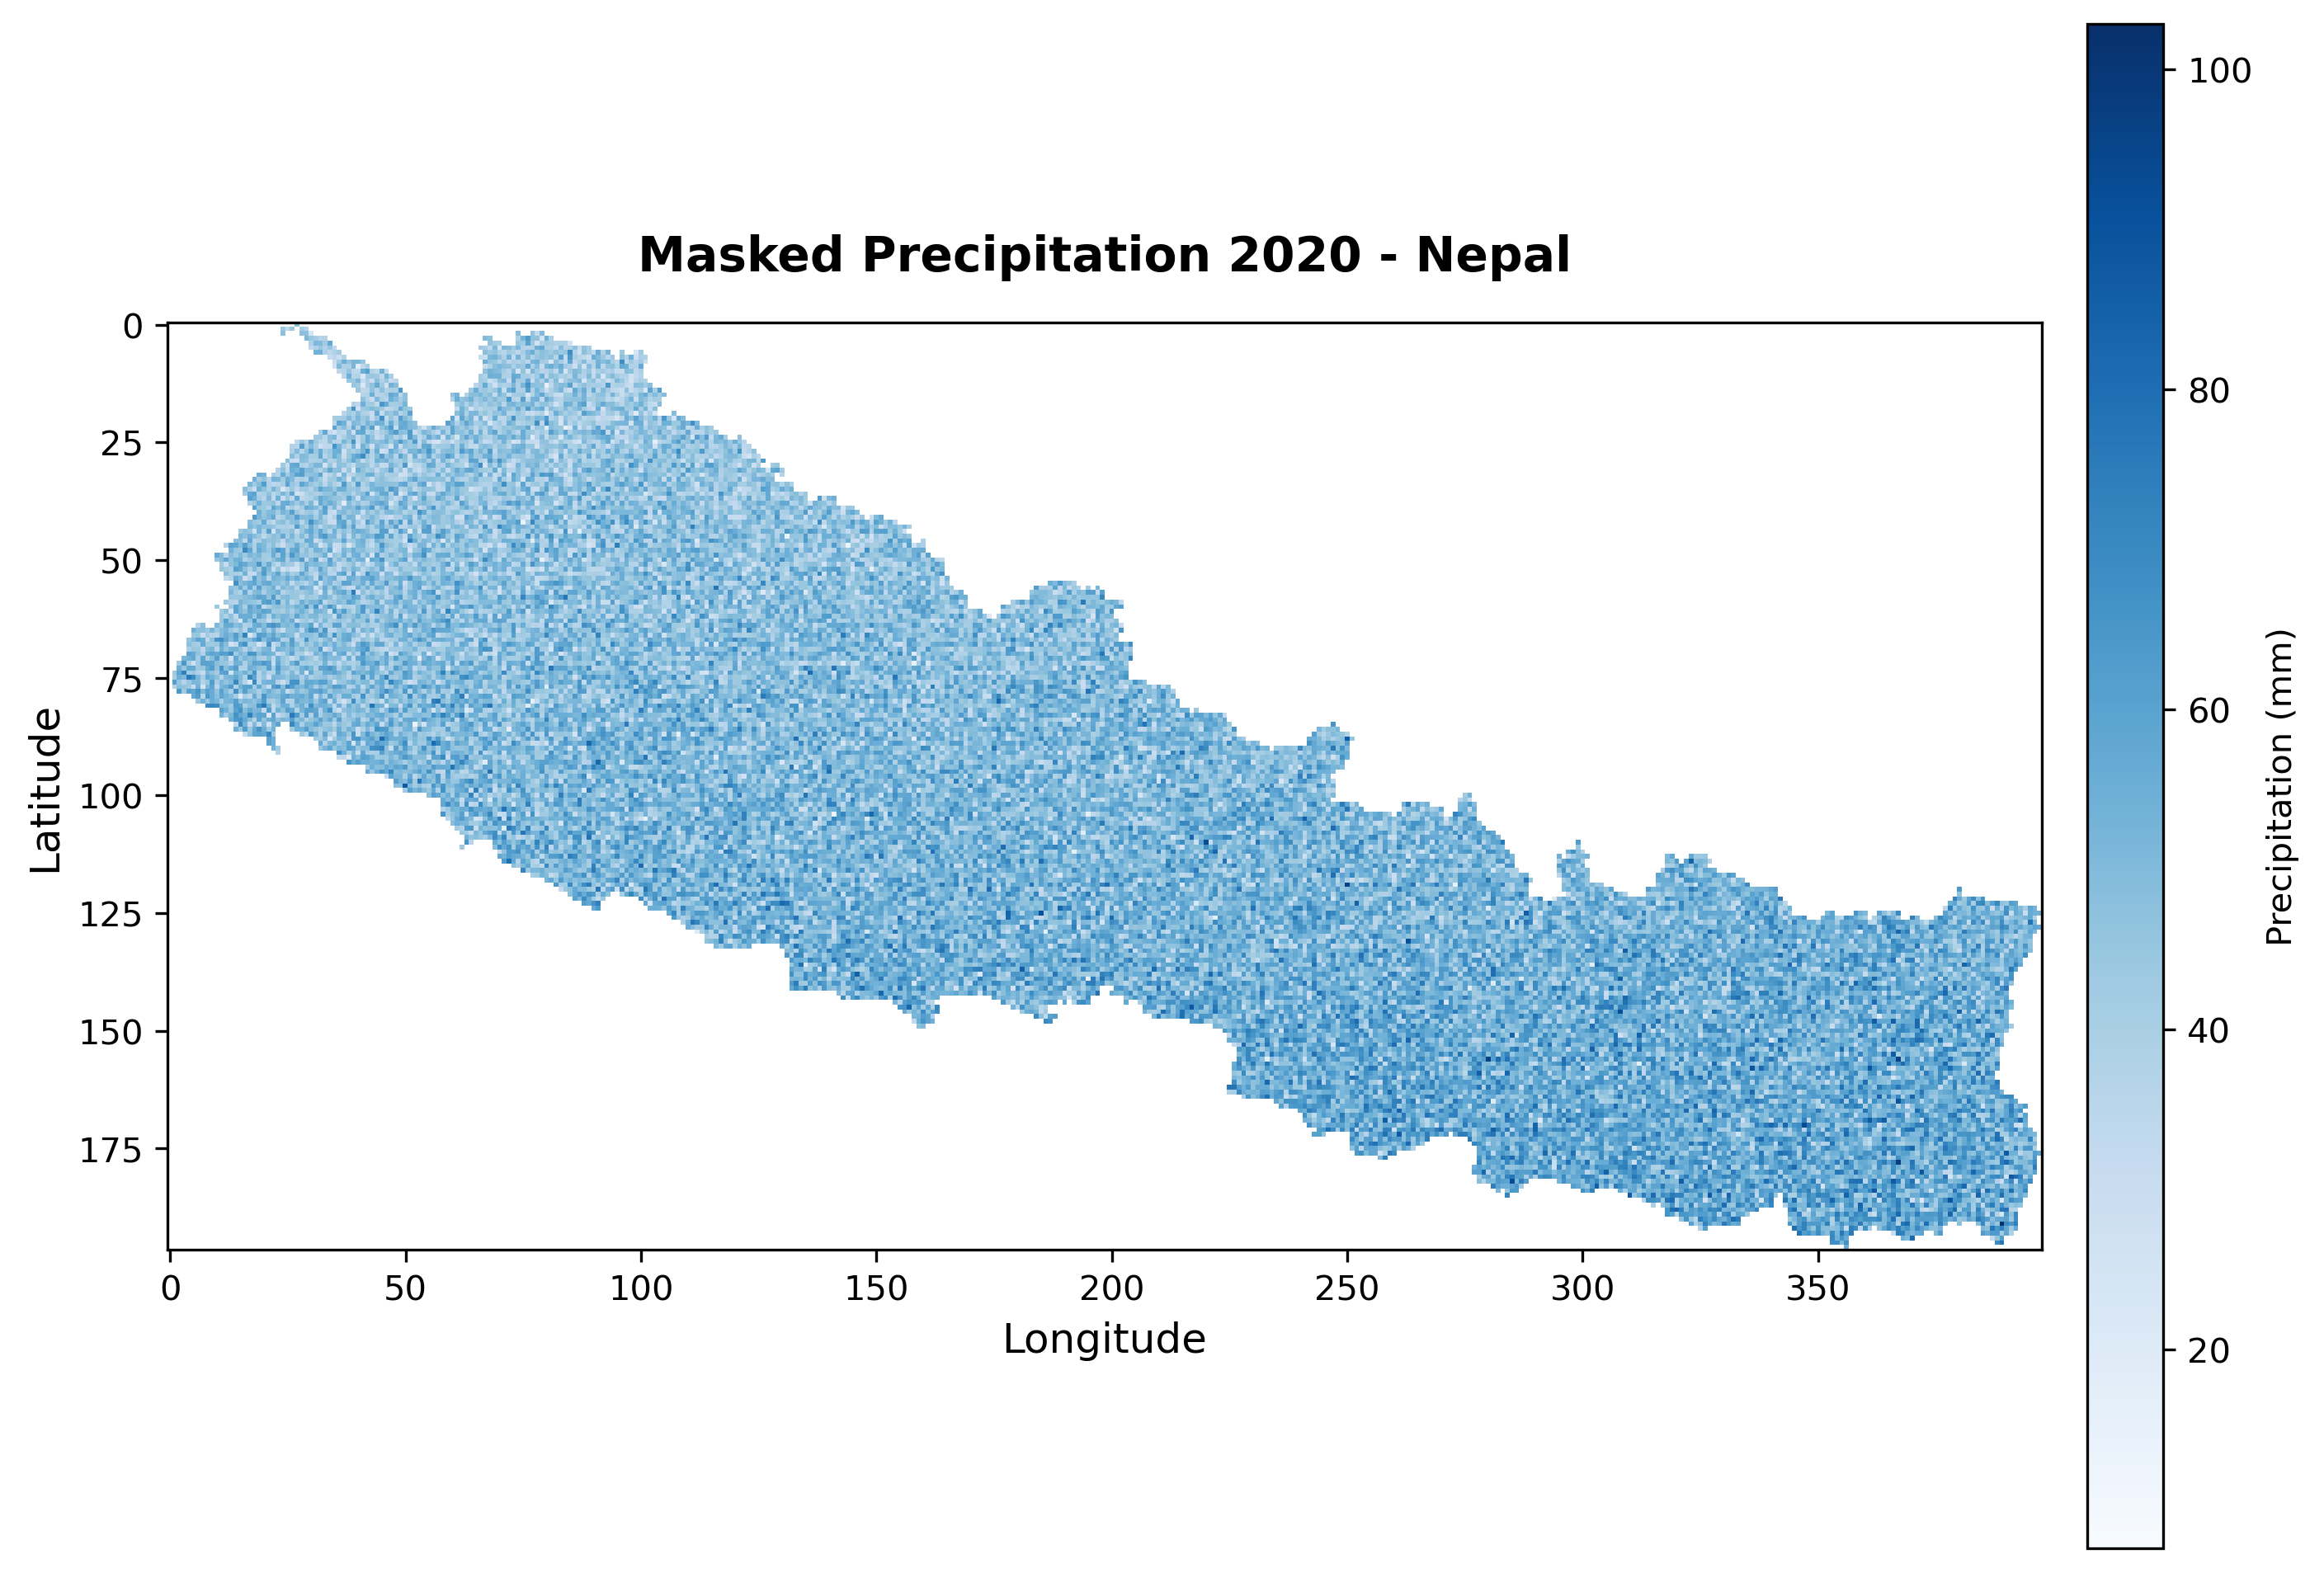

2025-03-18 11:19:40,690 - INFO - Plot displayed for: Masked Precipitation 2020 - Nepal
2025-03-18 11:19:40,691 - INFO - Starting raster masking process for Precipitation 2050...
2025-03-18 11:19:40,723 - INFO - Shapefile loaded successfully: data/Shape_Data/local_unit.shp
2025-03-18 11:19:41,564 - INFO - Raster masked successfully: data/nepal_climate_data/nepal_precipitation_2050.tif
2025-03-18 11:19:41,566 - INFO - Generating plot for Precipitation 2050...
2025-03-18 11:19:41,900 - INFO - Plot saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_precipitation_2050.png


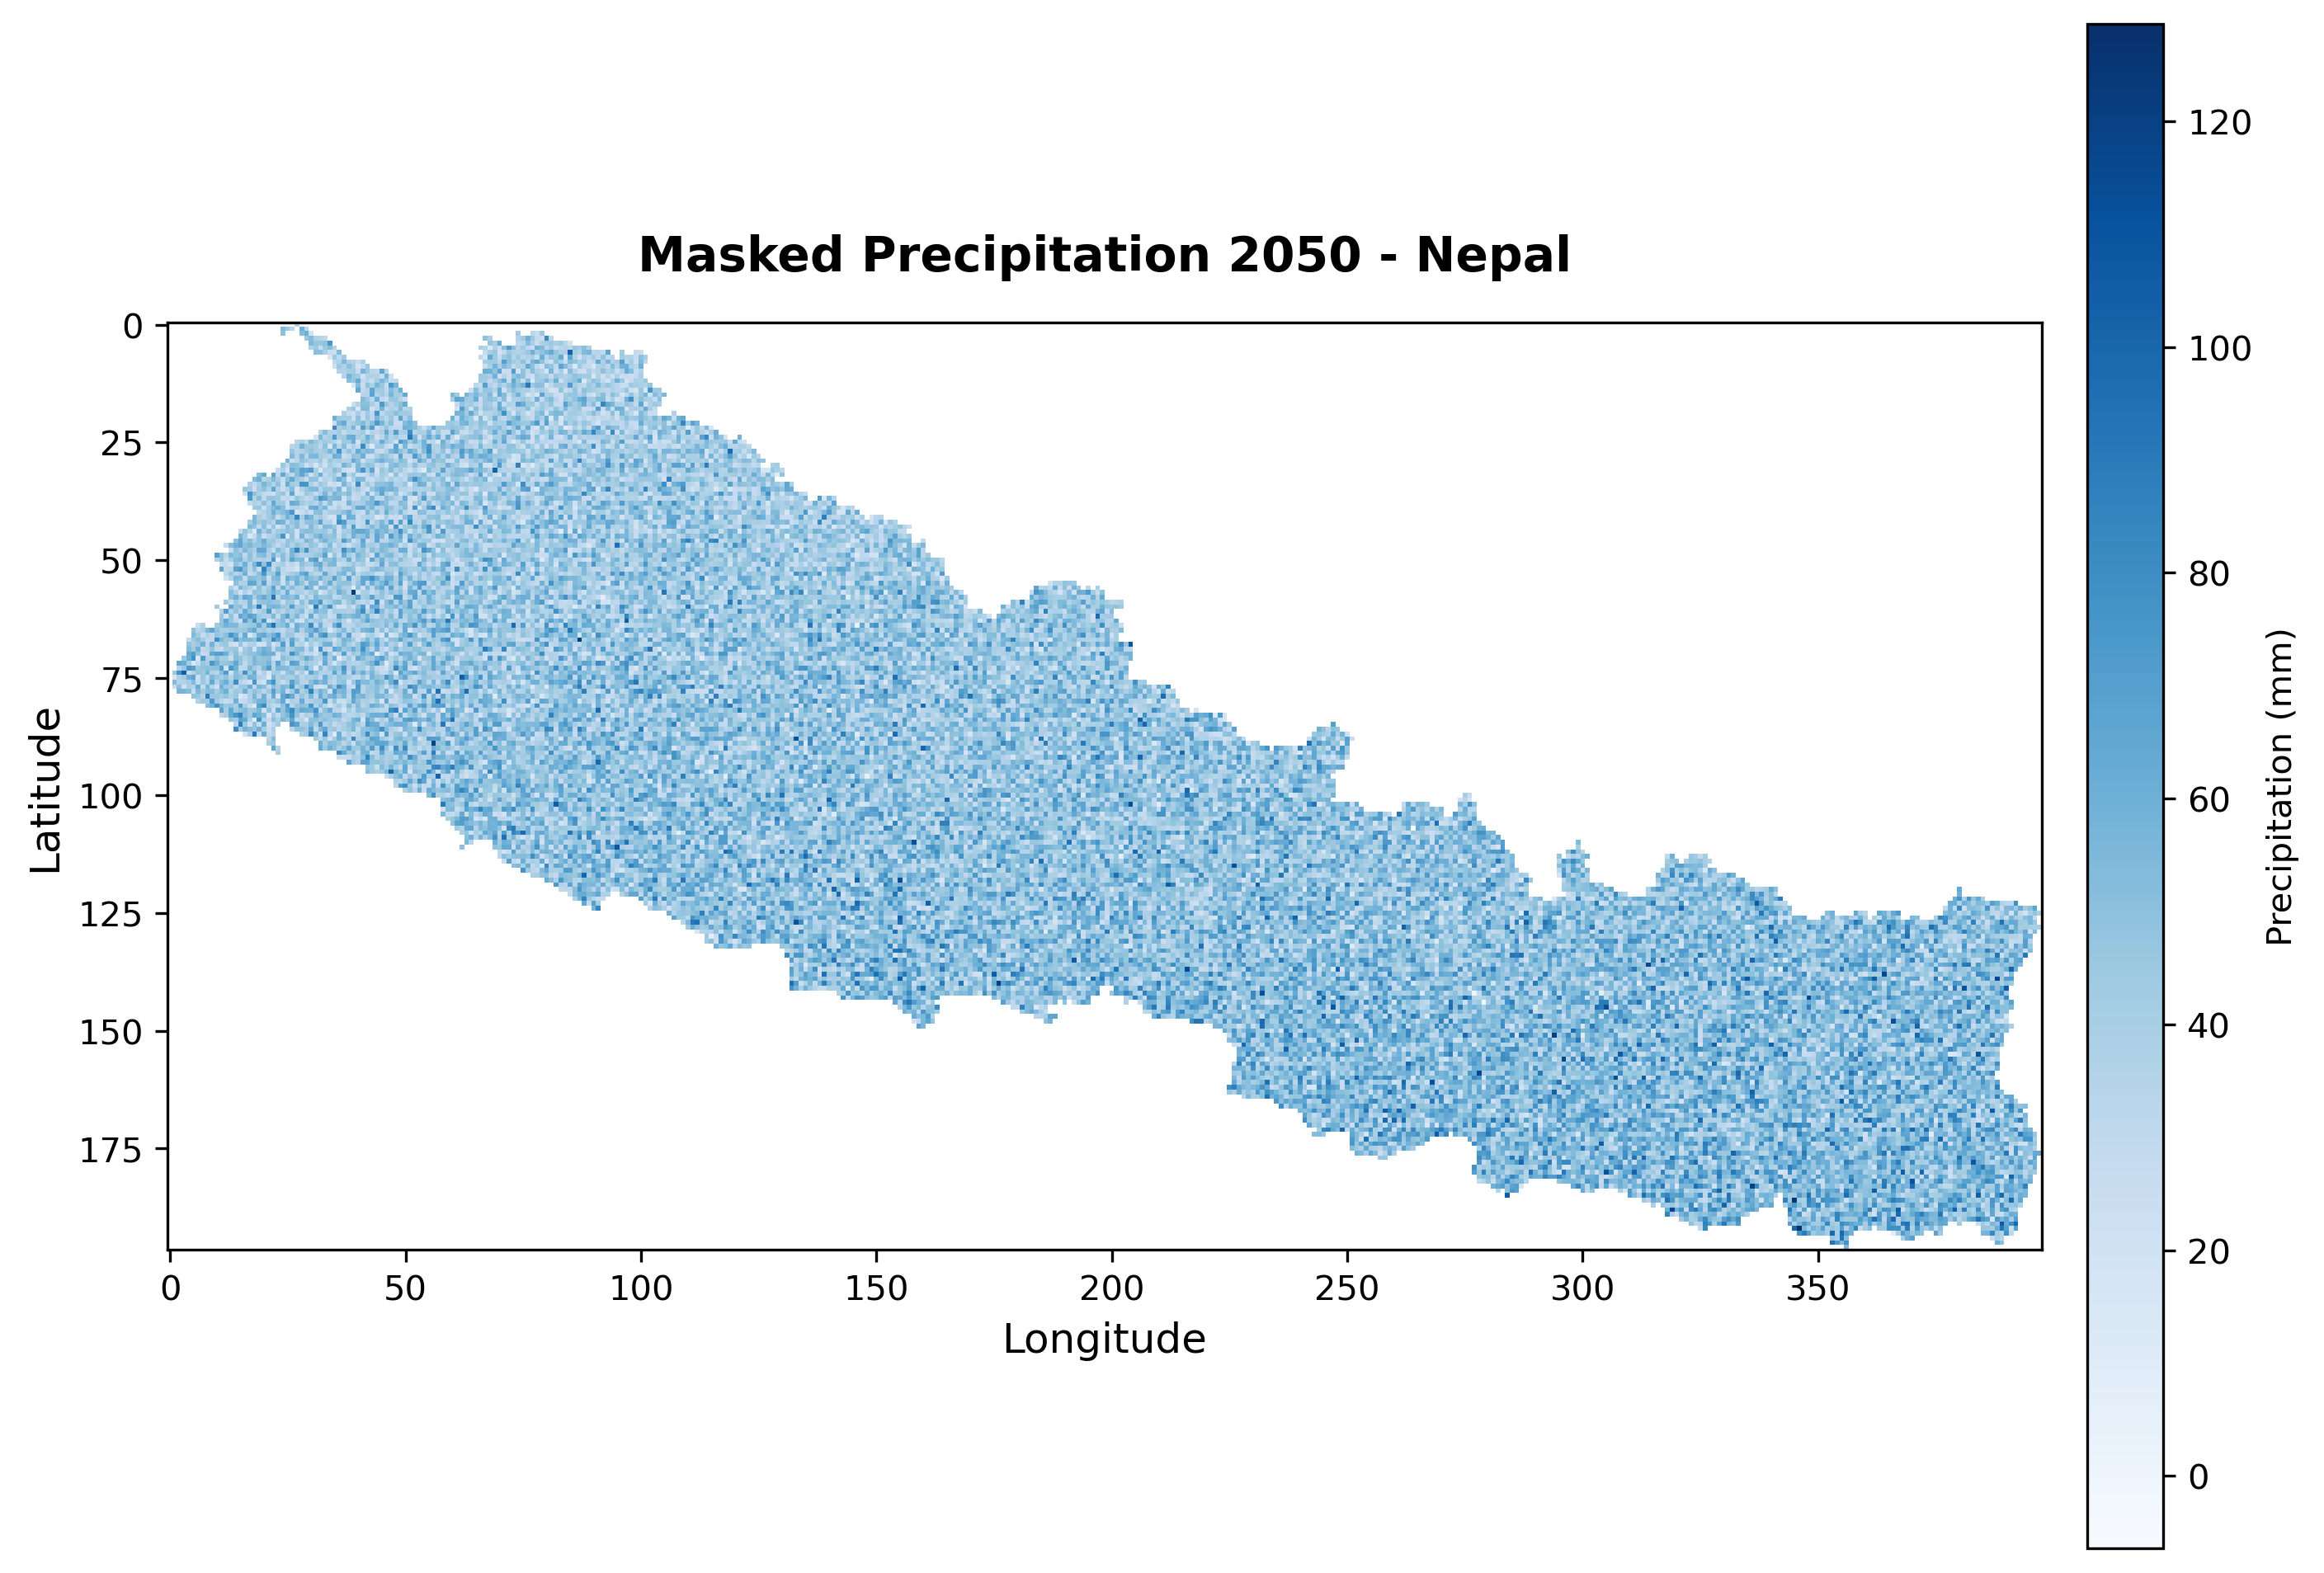

2025-03-18 11:19:42,128 - INFO - Plot displayed for: Masked Precipitation 2050 - Nepal
2025-03-18 11:19:42,128 - INFO - Starting raster masking process for Temperature 2020...
2025-03-18 11:19:42,160 - INFO - Shapefile loaded successfully: data/Shape_Data/local_unit.shp
2025-03-18 11:19:43,011 - INFO - Raster masked successfully: data/nepal_climate_data/nepal_temperature_2020.tif
2025-03-18 11:19:43,013 - INFO - Generating plot for Temperature 2020...
2025-03-18 11:19:43,351 - INFO - Plot saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_temperature_2020.png


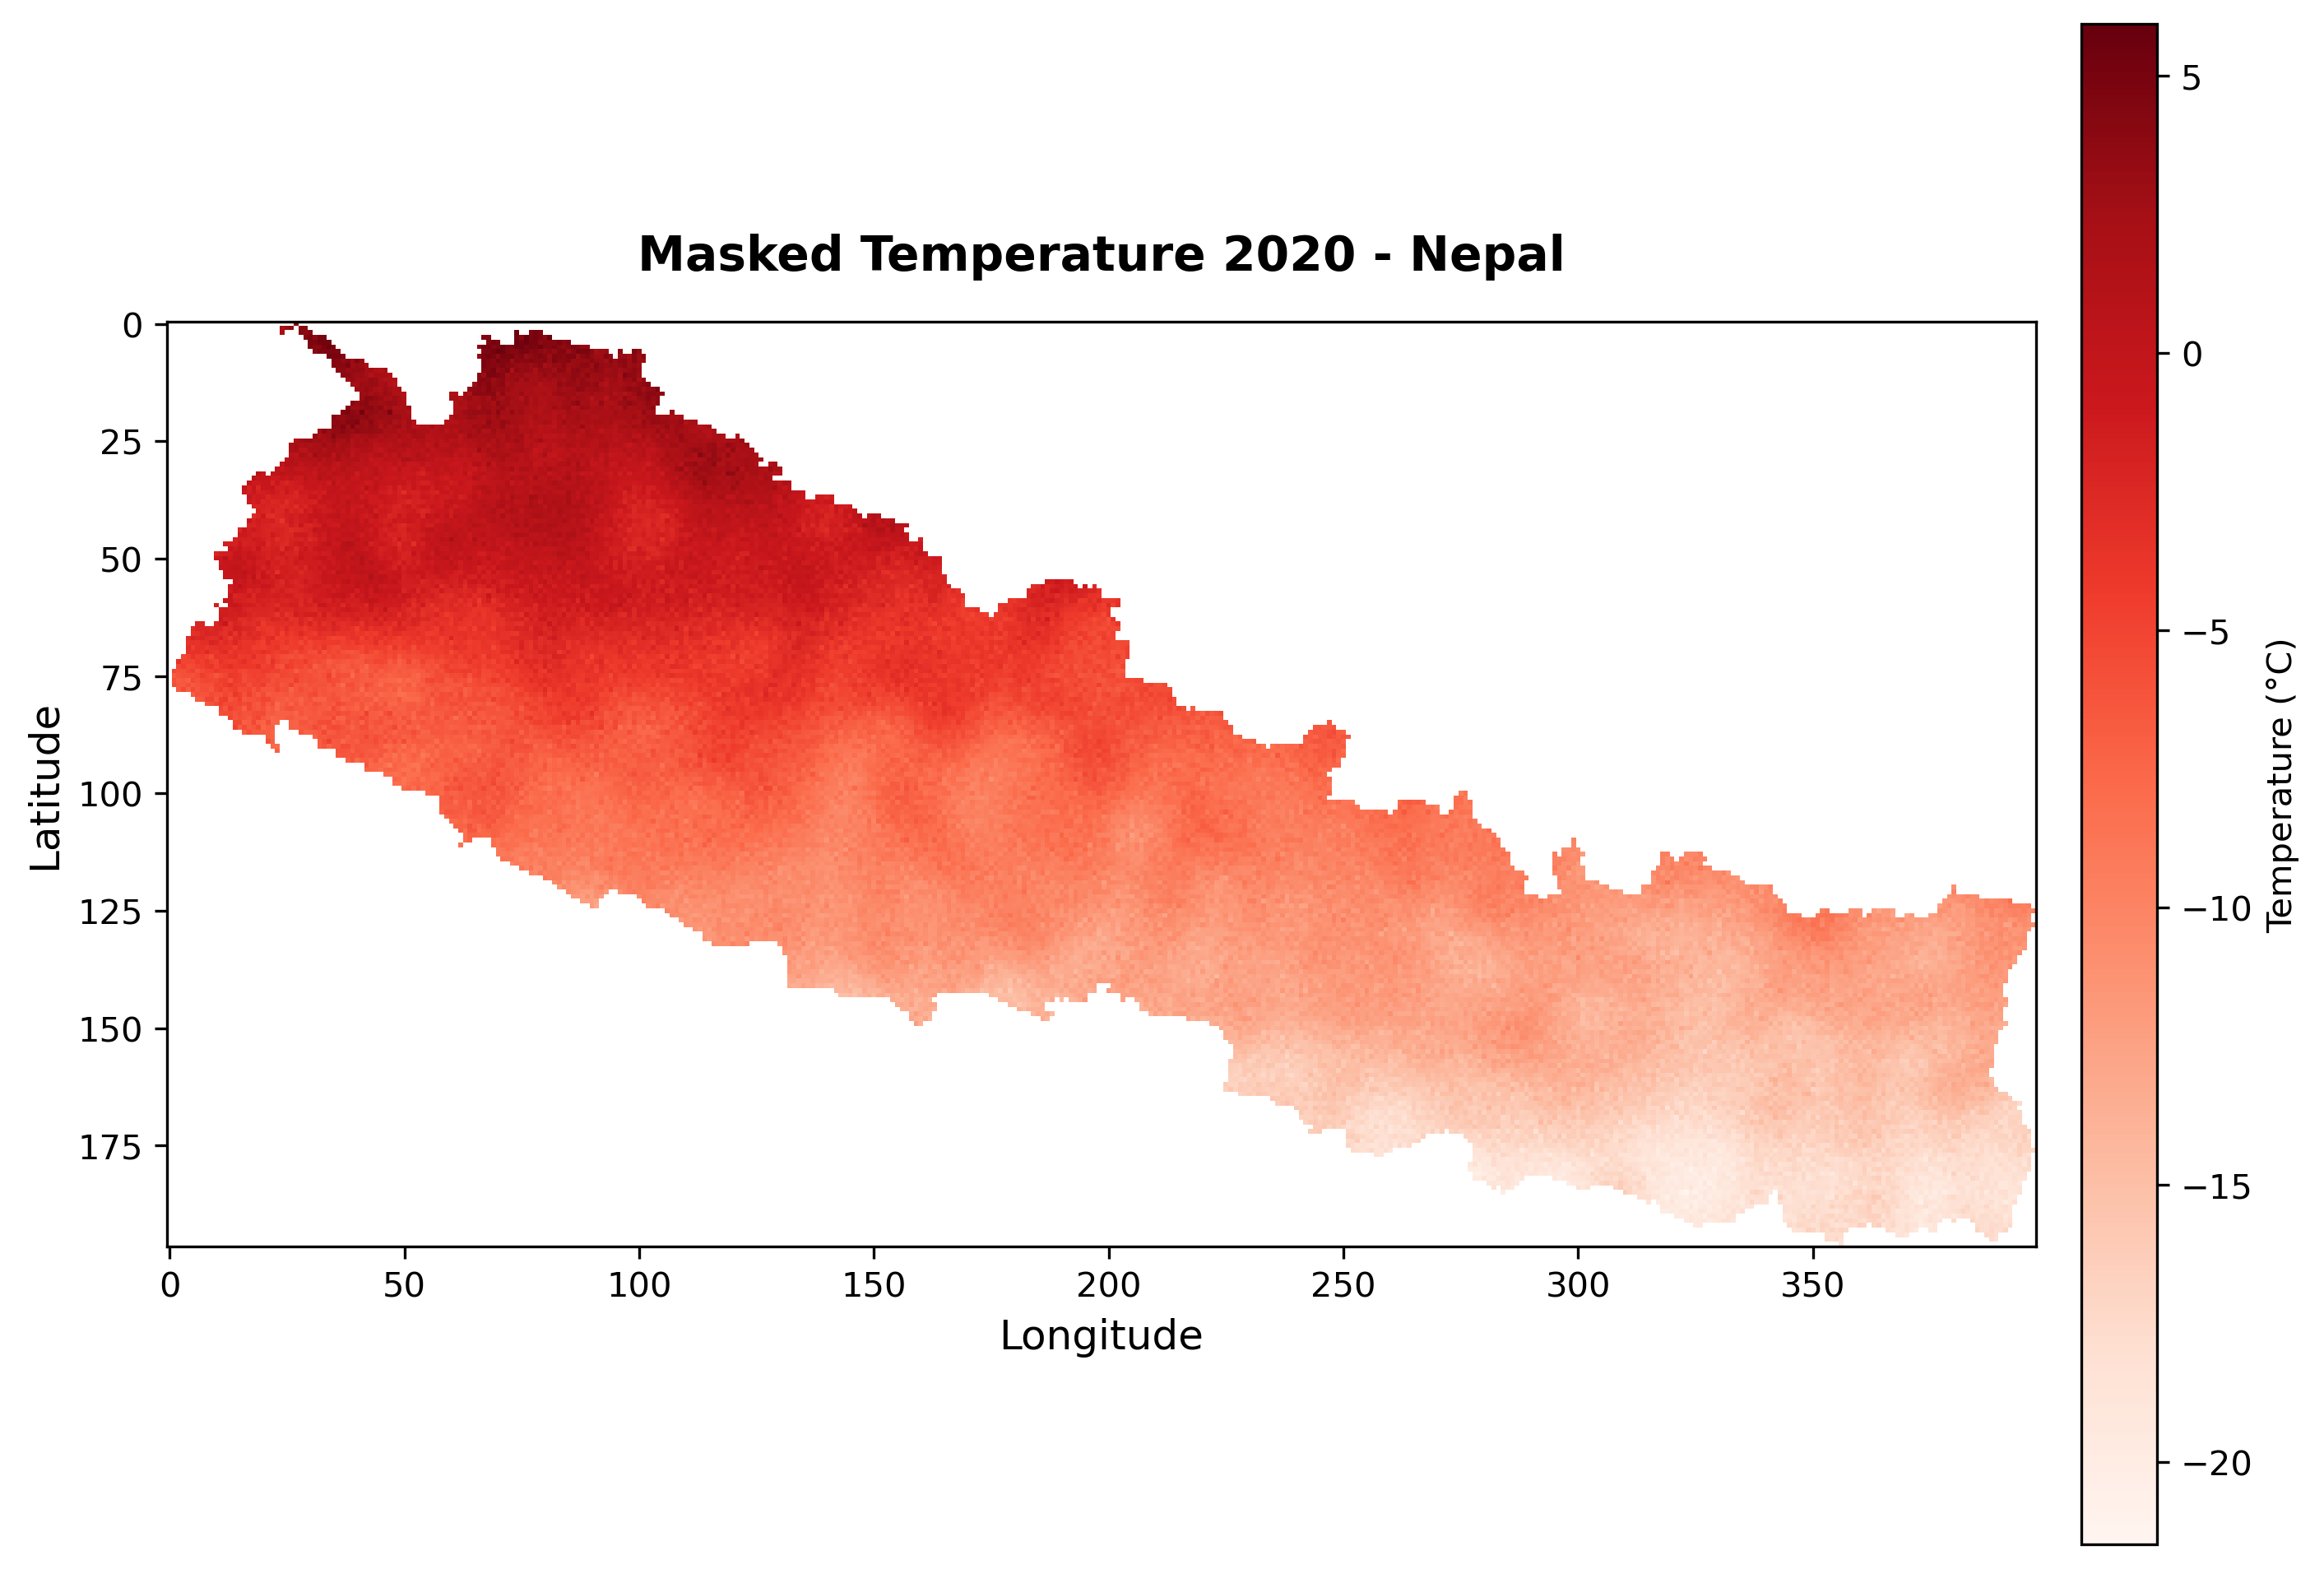

2025-03-18 11:19:43,577 - INFO - Plot displayed for: Masked Temperature 2020 - Nepal
2025-03-18 11:19:43,577 - INFO - Starting raster masking process for Temperature 2050...
2025-03-18 11:19:43,611 - INFO - Shapefile loaded successfully: data/Shape_Data/local_unit.shp
2025-03-18 11:19:44,454 - INFO - Raster masked successfully: data/nepal_climate_data/nepal_temperature_2050.tif
2025-03-18 11:19:44,456 - INFO - Generating plot for Temperature 2050...
2025-03-18 11:19:44,783 - INFO - Plot saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_temperature_2050.png


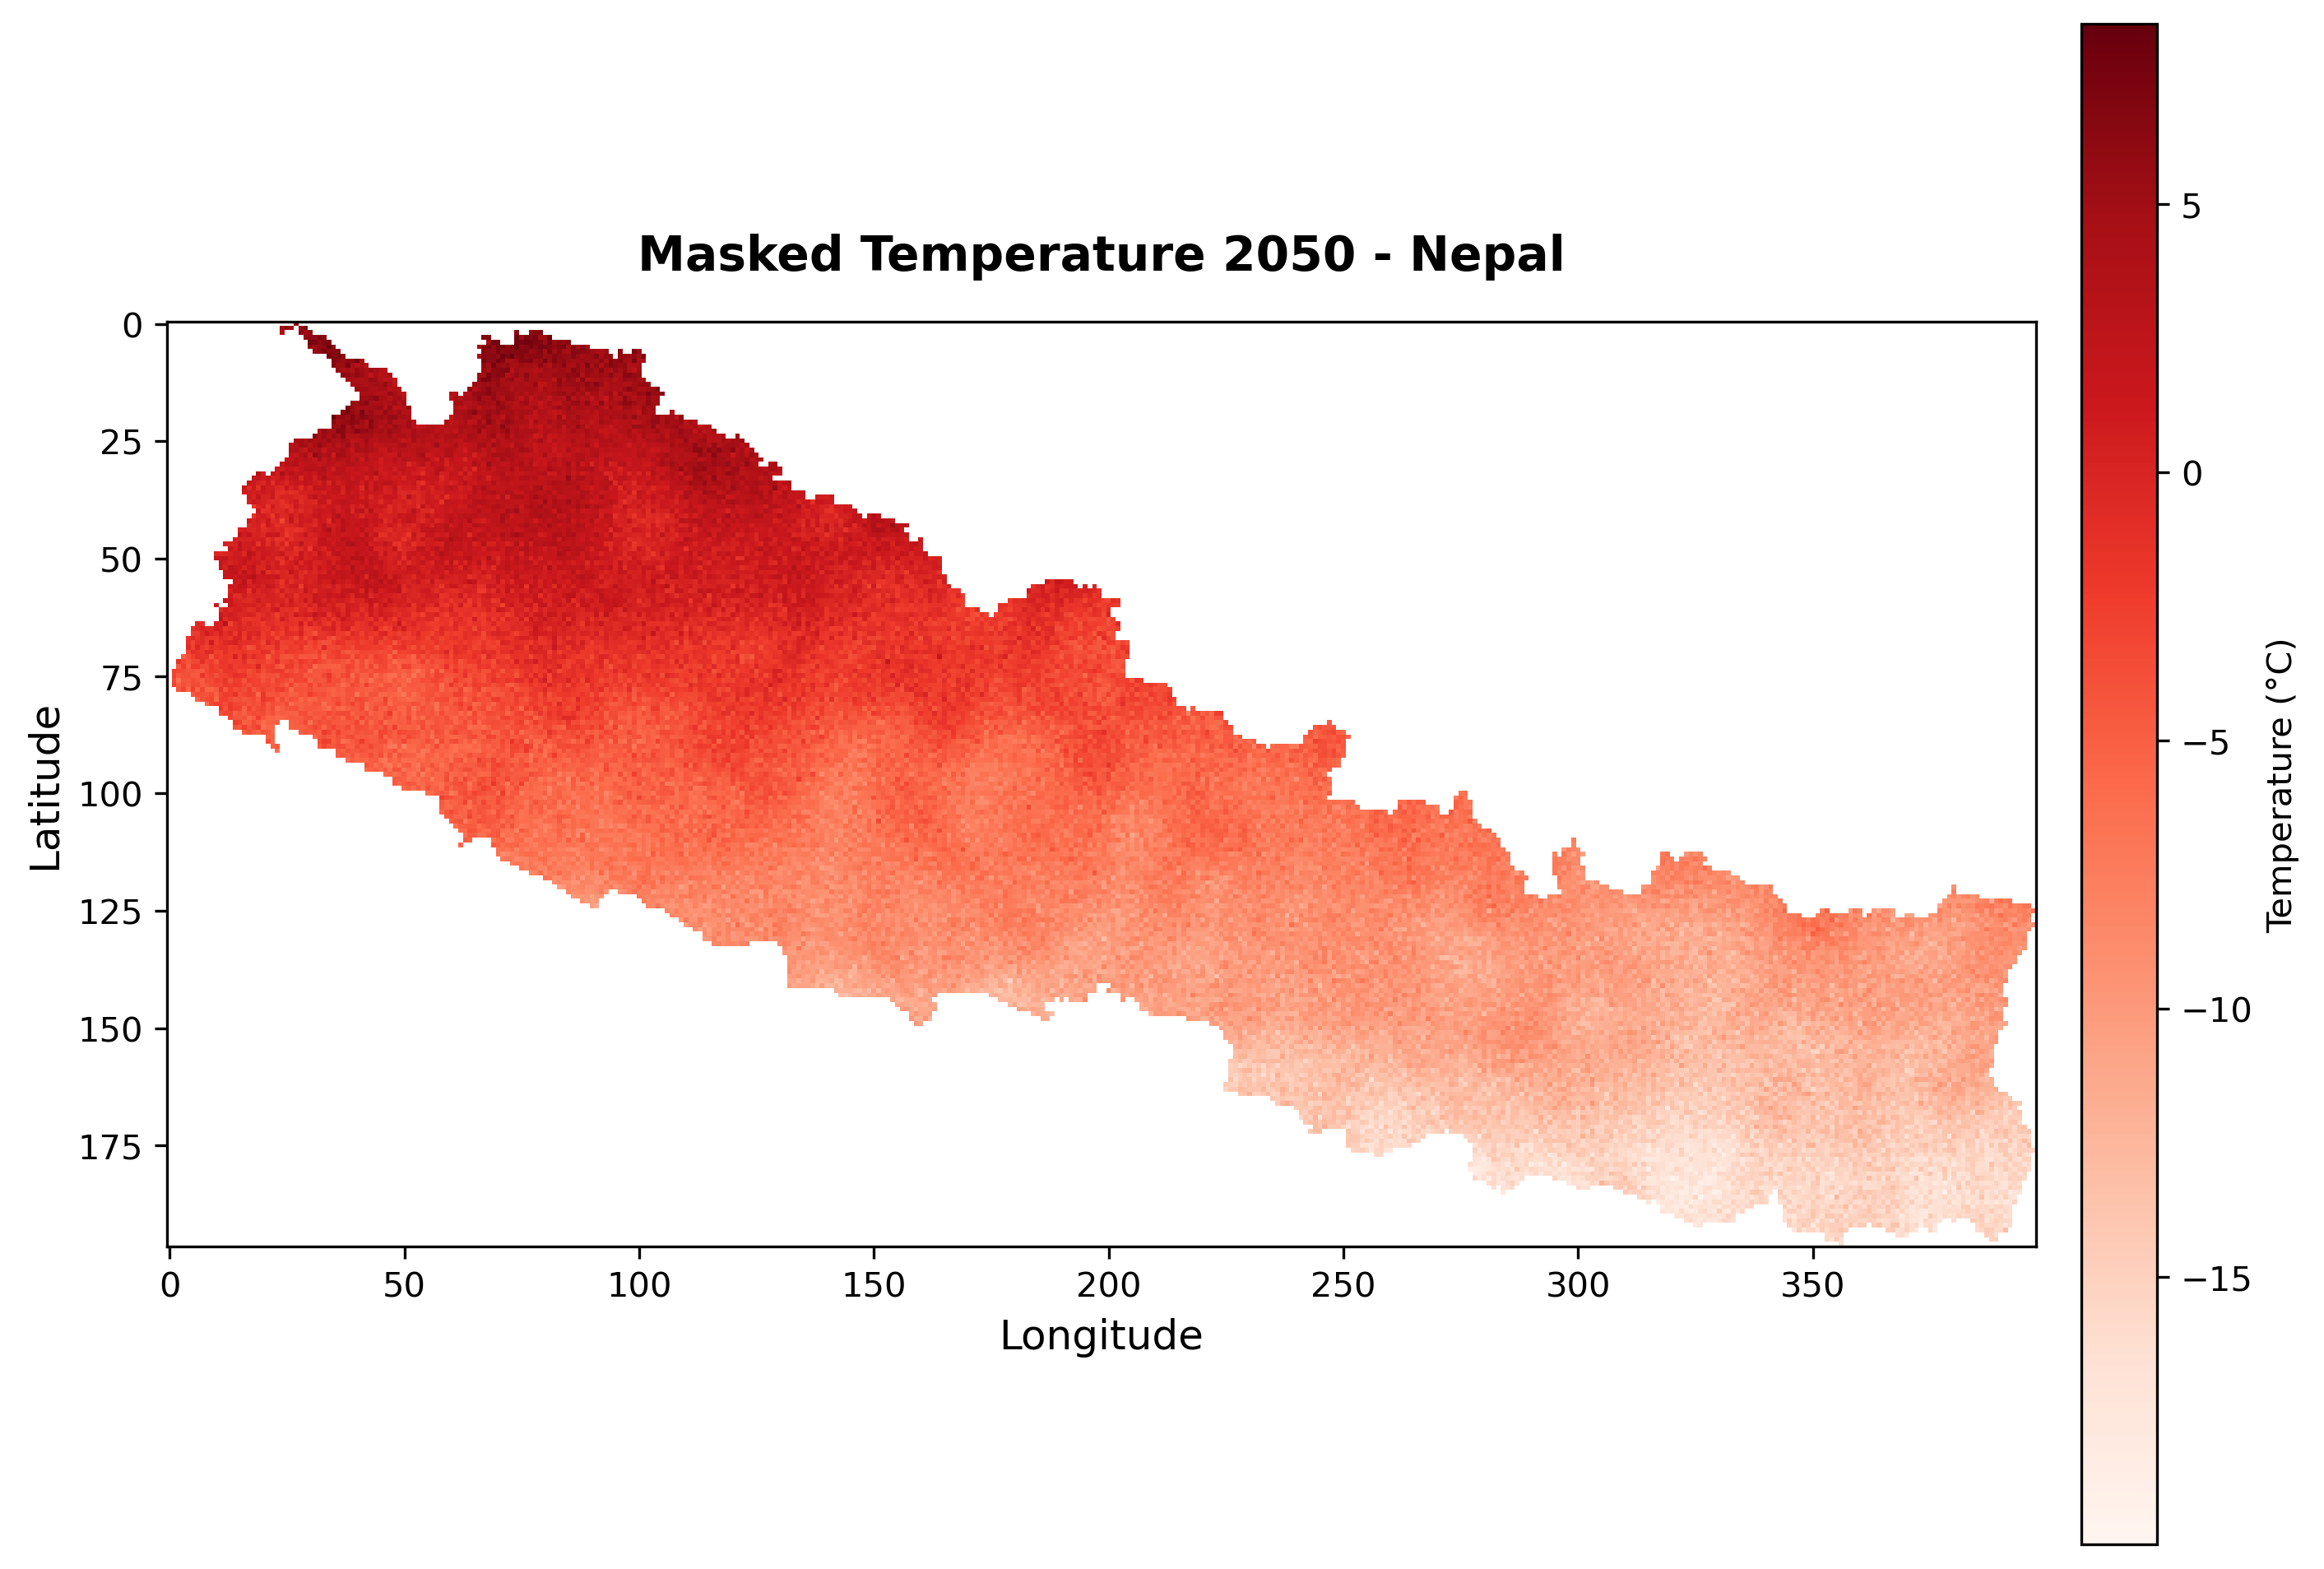

2025-03-18 11:19:45,012 - INFO - Plot displayed for: Masked Temperature 2050 - Nepal
2025-03-18 11:19:45,013 - INFO - All processes completed successfully


In [22]:
# Step 6: Execute the main process to mask and plot precipitation and temperature data
# Define file paths for all four inputs (adjust these to your actual readable locations)
raster_precipitation_path_2020 = "data/nepal_climate_data/nepal_precipitation_2020.tif"  # Precipitation 2020
raster_precipitation_path_2050 = "data/nepal_climate_data/nepal_precipitation_2050.tif"  # Precipitation 2050
raster_temperature_path_2020 = "data/nepal_climate_data/nepal_temperature_2020.tif"      # Temperature 2020
raster_temperature_path_2050 = "data/nepal_climate_data/nepal_temperature_2050.tif"      # Temperature 2050
shapefile_path = "data/Shape_Data/local_unit.shp"  # Shapefile for masking
output_dir = Path.cwd() / "output"  # Define output directory as 'output' in current working directory

try:
    # Ensure all input paths are readable
    input_files = {
        "Precipitation 2020": raster_precipitation_path_2020,
        "Precipitation 2050": raster_precipitation_path_2050,
        "Temperature 2020": raster_temperature_path_2020,
        "Temperature 2050": raster_temperature_path_2050,
        "Shapefile": shapefile_path
    }
    for name, path in input_files.items():
        if not Path(path).is_file():
            raise FileNotFoundError(f"Input file not found or inaccessible: {path} ({name})")

    # Check and create output directory if it doesn't exist
    if not output_dir.exists():
        if is_writable(Path.cwd()):  # Check if current directory is writable
            output_dir.mkdir(parents=True, exist_ok=True)
            logger.info(f"Created output directory: {output_dir}")
        else:
            # Fallback to a temporary directory if current directory isn't writable
            import tempfile
            output_dir = Path(tempfile.gettempdir()) / "output"
            output_dir.mkdir(parents=True, exist_ok=True)
            logger.warning(f"Current directory not writable; using temporary directory: {output_dir}")
    elif not is_writable(output_dir):
        # If output_dir exists but isn't writable, use a temporary directory
        import tempfile
        output_dir = Path(tempfile.gettempdir()) / "output"
        output_dir.mkdir(parents=True, exist_ok=True)
        logger.warning(f"Output directory not writable; using temporary directory: {output_dir}")

    # Define output paths for each dataset
    output_paths = {
        "precipitation_2020": output_dir / "nepal_precipitation_2020.png",
        "precipitation_2050": output_dir / "nepal_precipitation_2050.png",
        "temperature_2020": output_dir / "nepal_temperature_2020.png",
        "temperature_2050": output_dir / "nepal_temperature_2050.png"
    }
    logger.info(f"Output directory set to: {output_dir}")

    # Process and plot each dataset, storing masked data
    datasets = [
        ("Precipitation 2020", raster_precipitation_path_2020, output_paths["precipitation_2020"], "Precipitation (mm)"),
        ("Precipitation 2050", raster_precipitation_path_2050, output_paths["precipitation_2050"], "Precipitation (mm)"),
        ("Temperature 2020", raster_temperature_path_2020, output_paths["temperature_2020"], "Temperature (°C)"),
        ("Temperature 2050", raster_temperature_path_2050, output_paths["temperature_2050"], "Temperature (°C)")
    ]
    masked_datasets = {}  # Dictionary to store masked data for EDA

    for title, raster_path, output_path, unit in datasets:
        # Apply masking to the raster data
        logger.info(f"Starting raster masking process for {title}...")
        masked_data = mask_raster(raster_path, shapefile_path)
        masked_datasets[title] = masked_data  # Store masked data

        # Plot the masked raster with a professional layout (will display and save)
        logger.info(f"Generating plot for {title}...")
        plot_masked_raster(
            masked_data=masked_data,
            title=f"Masked {title} - Nepal",
            output_path=output_path,  # Save to file
            unit=unit  # Pass the appropriate unit
        )

    # Log successful completion
    logger.info("All processes completed successfully")

except Exception as e:
    # Log any errors that occur during execution
    logger.error(f"Process failed: {str(e)}")
    raise

### Step 7: Statistical Analysis

In [23]:
# Step 7: Perform statistical analysis on the masked datasets
import pandas as pd  # For displaying statistics in a table

try:
    # Compute statistics for each masked dataset
    stats = {}
    for title, masked_data in masked_datasets.items():
        # Flatten the masked data and remove NaN values for statistics
        data_flat = masked_data.flatten()
        data_clean = data_flat[~np.isnan(data_flat)]
        
        if len(data_clean) == 0:
            logger.warning(f"No valid data points for {title} after removing NaN")
            stats[title] = {"Mean": np.nan, "Median": np.nan, "Min": np.nan, "Max": np.nan, "Std Dev": np.nan}
        else:
            stats[title] = {
                "Mean": np.mean(data_clean),
                "Median": np.median(data_clean),
                "Min": np.min(data_clean),
                "Max": np.max(data_clean),
                "Std Dev": np.std(data_clean)
            }
        logger.info(f"Computed statistics for {title}")

    # Display statistics in a table using pandas
    stats_df = pd.DataFrame(stats).T  # Transpose to have datasets as rows
    stats_df.index.name = "Dataset"
    display(stats_df)  # Use display() for nice formatting in Jupyter

    # Log the statistics
    logger.info("Statistical analysis completed")

except Exception as e:
    logger.error(f"Statistical analysis failed: {str(e)}")
    raise

2025-03-18 11:19:49,442 - INFO - Computed statistics for Precipitation 2020
2025-03-18 11:19:49,444 - INFO - Computed statistics for Precipitation 2050
2025-03-18 11:19:49,445 - INFO - Computed statistics for Temperature 2020
2025-03-18 11:19:49,446 - INFO - Computed statistics for Temperature 2050


,Mean,Median,Min,Max,Std Dev
Dataset,,,,,
Precipitation 2020,51.343777,51.037933,7.565779,102.832674,11.004055
Precipitation 2050,48.772854,47.336479,-6.410086,128.622831,16.260331
Temperature 2020,-8.422842,-8.947582,-21.479173,5.929305,5.739927
Temperature 2050,-6.303371,-6.784432,-19.983062,8.354877,5.646982


2025-03-18 11:19:49,458 - INFO - Statistical analysis completed


### Step 8: Exploratory Data Analysis

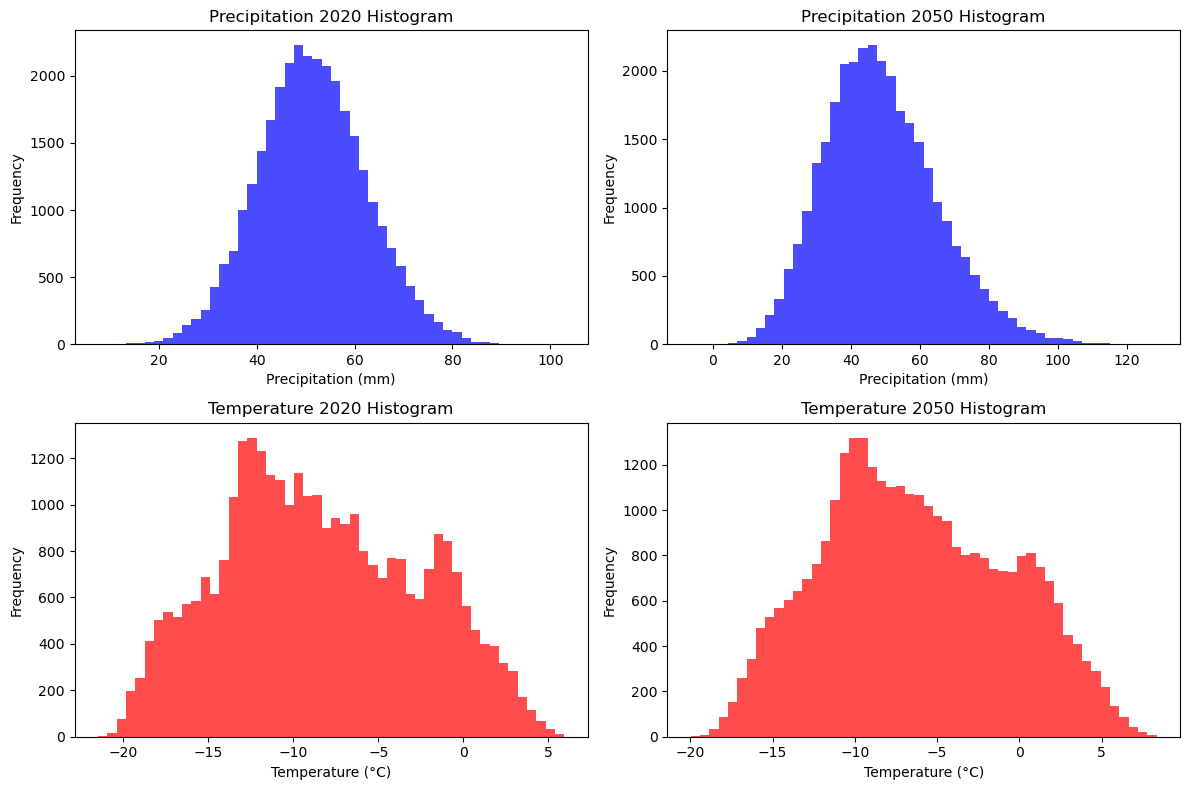

2025-03-18 11:21:03,444 - INFO - Displayed histograms for all datasets


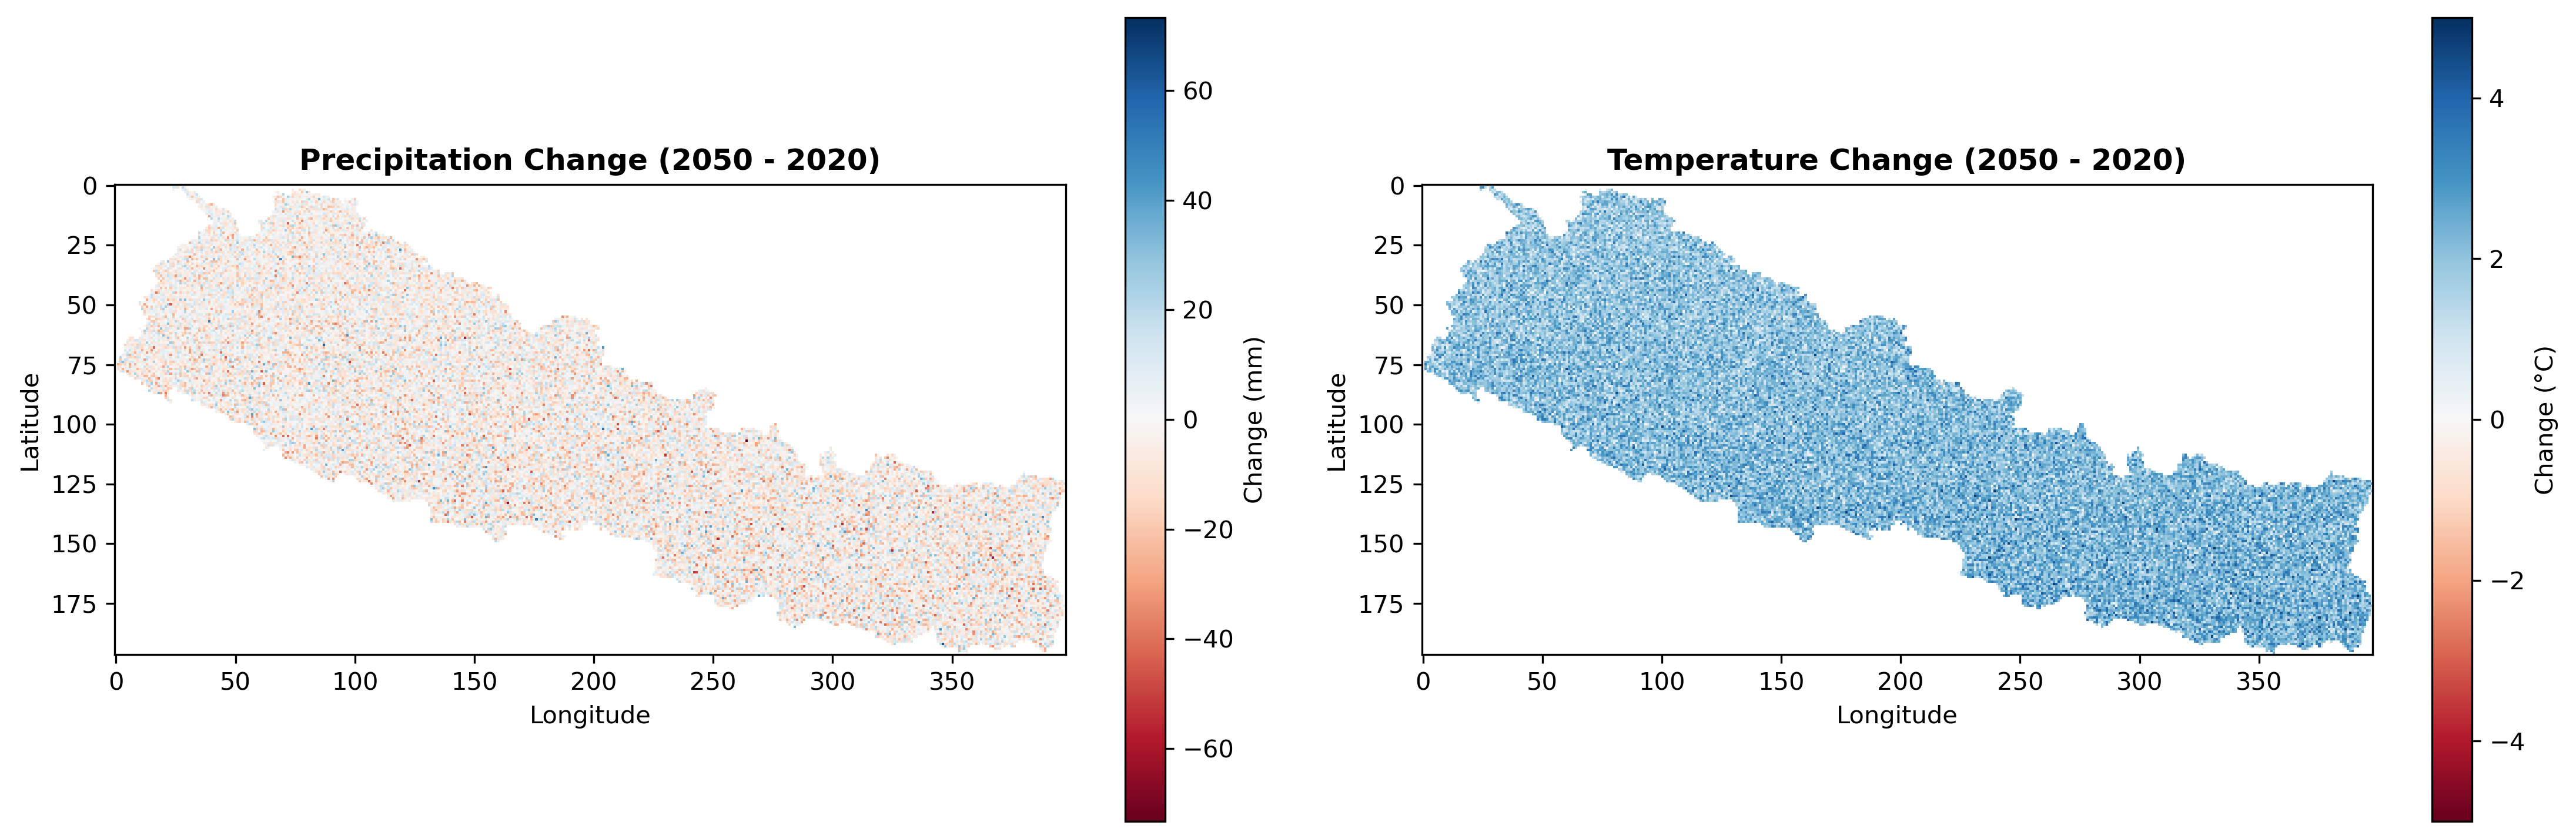

2025-03-18 11:21:04,105 - INFO - Precipitation difference map saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_precipitation_diff_2050_2020.png
2025-03-18 11:21:04,405 - INFO - Temperature difference map saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_temperature_diff_2050_2020.png


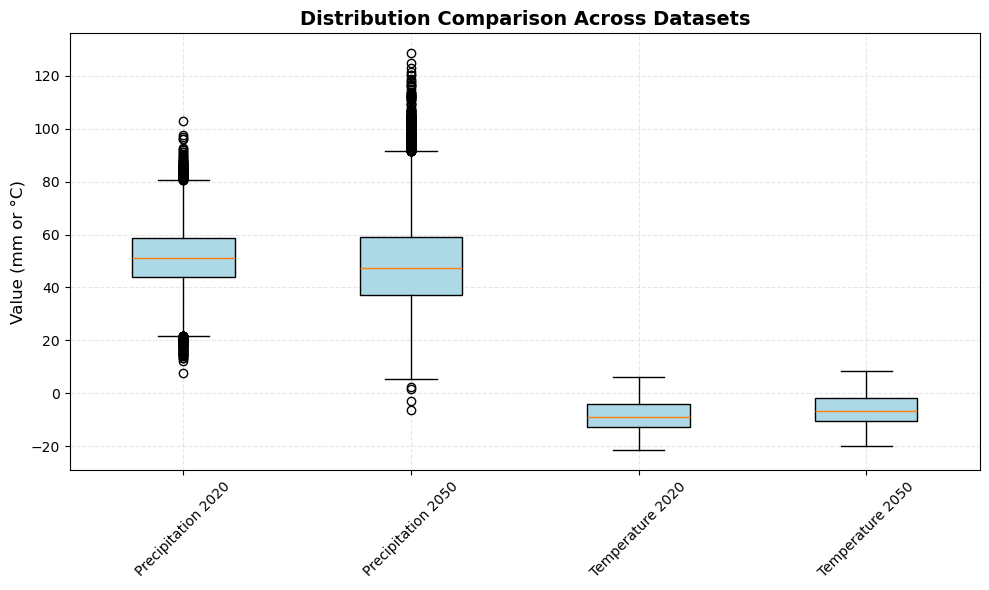

2025-03-18 11:21:04,465 - INFO - Displayed box plots for all datasets


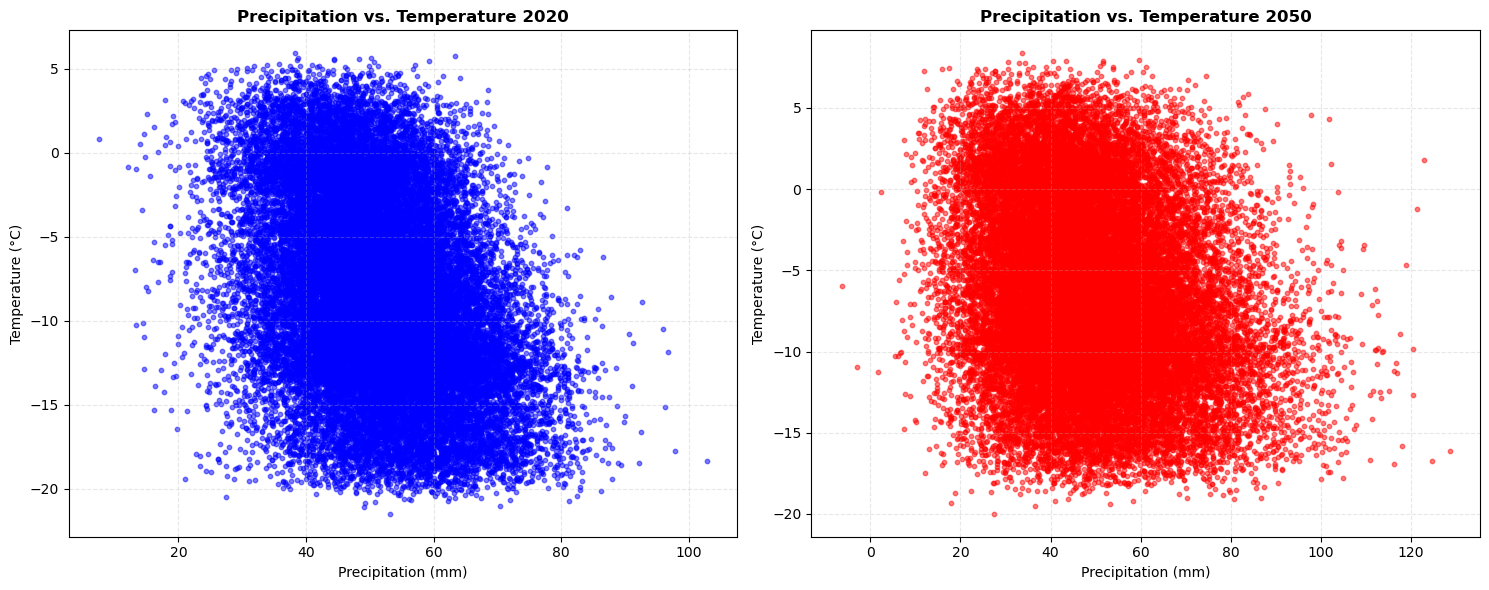

2025-03-18 11:21:04,921 - INFO - Scatter plots saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_precip_temp_scatter.png
2025-03-18 11:21:04,925 - INFO - Computed correlation matrix


,Precipitation 2020,Precipitation 2050,Temperature 2020,Temperature 2050
Precipitation 2020,1.000000,0.640959,-0.345414,-0.343680
Precipitation 2050,0.640959,1.000000,-0.224032,-0.222826
Temperature 2020,-0.345414,-0.224032,1.000000,0.991541
Temperature 2050,-0.343680,-0.222826,0.991541,1.000000


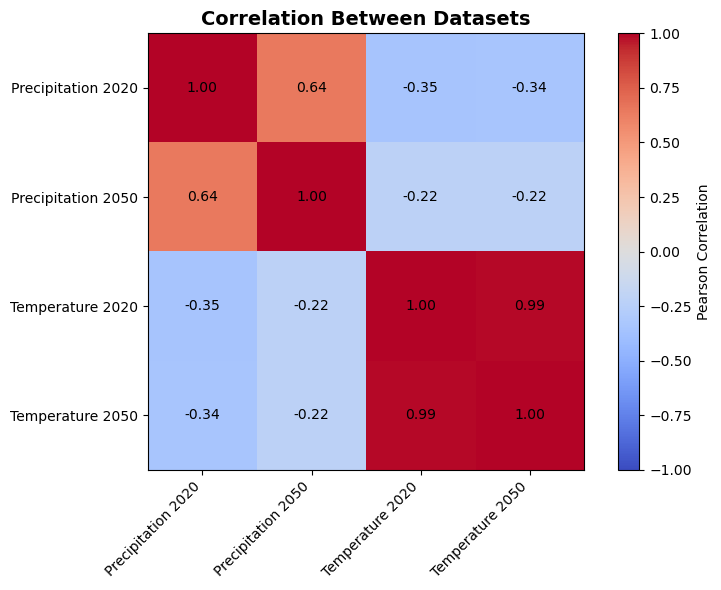

2025-03-18 11:21:04,999 - INFO - Correlation heatmap saved to: /Users/prakashpandey/Desktop/omdena/gis-data-science-assignment-pandeyprakash694/output/nepal_correlation_heatmap.png
2025-03-18 11:21:05,000 - INFO - Enhanced EDA visualizations completed


<Figure size 640x480 with 0 Axes>

In [25]:
try:
    # 1. Histograms for each dataset
    plt.figure(figsize=(12, 8))
    for i, (title, masked_data) in enumerate(masked_datasets.items(), 1):
        plt.subplot(2, 2, i)
        data_flat = masked_data.flatten()
        data_clean = data_flat[~np.isnan(data_flat)]
        if len(data_clean) > 0:
            plt.hist(data_clean, bins=50, color="blue" if "Precipitation" in title else "red", alpha=0.7)
            plt.title(f"{title} Histogram")
            plt.xlabel("Precipitation (mm)" if "Precipitation" in title else "Temperature (°C)")
            plt.ylabel("Frequency")
        else:
            plt.text(0.5, 0.5, "No valid data", ha="center", va="center")
            plt.title(f"{title} Histogram")
        plt.tight_layout()
    plt.show()
    logger.info("Displayed histograms for all datasets")

    # 2. Difference maps (2050 - 2020) for precipitation and temperature
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
    precip_diff = masked_datasets["Precipitation 2050"] - masked_datasets["Precipitation 2020"]
    im1 = axes[0].imshow(precip_diff, cmap="RdBu", vmin=-np.nanmax(np.abs(precip_diff)), vmax=np.nanmax(np.abs(precip_diff)))
    axes[0].set_title("Precipitation Change (2050 - 2020)", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Longitude", fontsize=10)
    axes[0].set_ylabel("Latitude", fontsize=10)
    plt.colorbar(im1, ax=axes[0], label="Change (mm)", shrink=0.8)

    temp_diff = masked_datasets["Temperature 2050"] - masked_datasets["Temperature 2020"]
    im2 = axes[1].imshow(temp_diff, cmap="RdBu", vmin=-np.nanmax(np.abs(temp_diff)), vmax=np.nanmax(np.abs(temp_diff)))
    axes[1].set_title("Temperature Change (2050 - 2020)", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Longitude", fontsize=10)
    axes[1].set_ylabel("Latitude", fontsize=10)
    plt.colorbar(im2, ax=axes[1], label="Change (°C)", shrink=0.8)

    plt.tight_layout()
    plt.show()
    
    diff_output_path_precip = output_dir / "nepal_precipitation_diff_2050_2020.png"
    diff_output_path_temp = output_dir / "nepal_temperature_diff_2050_2020.png"
    fig.savefig(diff_output_path_precip, bbox_inches='tight', format='png')
    logger.info(f"Precipitation difference map saved to: {diff_output_path_precip}")
    fig.savefig(diff_output_path_temp, bbox_inches='tight', format='png')
    logger.info(f"Temperature difference map saved to: {diff_output_path_temp}")
    plt.close(fig)

    # 3. Box plots for distribution comparison
    plt.figure(figsize=(10, 6))
    data_to_plot = []
    labels = []
    for title, masked_data in masked_datasets.items():
        data_flat = masked_data.flatten()
        data_clean = data_flat[~np.isnan(data_flat)]
        if len(data_clean) > 0:
            data_to_plot.append(data_clean)
            labels.append(title)
    if data_to_plot:
        plt.boxplot(data_to_plot, labels=labels, patch_artist=True, 
                    boxprops=dict(facecolor="lightblue" if "Precipitation" in labels[0] else "lightcoral"))
        plt.title("Distribution Comparison Across Datasets", fontsize=14, fontweight='bold')
        plt.ylabel("Value (mm or °C)", fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        logger.info("Displayed box plots for all datasets")
    else:
        logger.warning("No valid data for box plots")

    # 4. Scatter plots: Precipitation vs. Temperature for 2020 and 2050
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for i, year in enumerate(["2020", "2050"]):
        precip = masked_datasets[f"Precipitation {year}"].flatten()
        temp = masked_datasets[f"Temperature {year}"].flatten()
        mask = ~np.isnan(precip) & ~np.isnan(temp)  # Remove NaN pairs
        if np.sum(mask) > 0:
            axes[i].scatter(precip[mask], temp[mask], alpha=0.5, c="blue" if year == "2020" else "red", s=10)
            axes[i].set_title(f"Precipitation vs. Temperature {year}", fontsize=12, fontweight='bold')
            axes[i].set_xlabel("Precipitation (mm)", fontsize=10)
            axes[i].set_ylabel("Temperature (°C)", fontsize=10)
            axes[i].grid(True, linestyle='--', alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, "No valid data", ha="center", va="center")
        plt.tight_layout()
    plt.show()
    scatter_output_path = output_dir / "nepal_precip_temp_scatter.png"
    fig.savefig(scatter_output_path, bbox_inches='tight', format='png')
    logger.info(f"Scatter plots saved to: {scatter_output_path}")

    # 5. Correlation analysis
    correlation_data = {}
    for title, masked_data in masked_datasets.items():
        correlation_data[title] = masked_data.flatten()[~np.isnan(masked_data.flatten())]
    
    corr_df = pd.DataFrame(correlation_data)
    correlation_matrix = corr_df.corr(method="pearson")
    logger.info("Computed correlation matrix")
    display(correlation_matrix)

    # Heatmap of correlations
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="Pearson Correlation")
    plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45, ha="right")
    plt.yticks(range(len(correlation_matrix)), correlation_matrix.index)
    for i in range(len(correlation_matrix)):
        for j in range(len(correlation_matrix)):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")
    plt.title("Correlation Between Datasets", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    corr_output_path = output_dir / "nepal_correlation_heatmap.png"
    plt.savefig(corr_output_path, bbox_inches='tight', format='png')
    logger.info(f"Correlation heatmap saved to: {corr_output_path}")

    logger.info("Enhanced EDA visualizations completed")

except Exception as e:
    logger.error(f"EDA visualizations failed: {str(e)}")
    raise